# The Plesser Problem

<img src="plesser_problem.png" width="300"/>

In [1]:
import math
import copy
import time
import IPython
import networkx as nx
import matplotlib.pyplot as plt

from plesser_utils import (
    draw_node_edges, 
    get_pairs, 
    reverse_destination_order,
    hash_graph
)

## Graph data model

Each graph is represented as an array of tuples.

Each tuple contains the name of a node and an list of destination nodes that the node connects to in clockwise order.
The destination nodes MUST be in clockwise order for the search algorithm to work.

Black nodes are denoted with a `b`, white nodes with a `w`, and edge nodes with an `e`.

In [2]:
starting_node_edges = [
    ('w1', ['e1', 'b1', 'b8']), ('w2', ['b1', 'b2', 'b3']), ('w3', ['b2', 'b4', 'b3']), ('w4', ['b4', 'e5', 'b5']),
    ('w5', ['b3', 'b5', 'w7']), ('w6', ['b5', 'e6', 'b6']), ('w7', ['w5', 'b6', 'b8']), ('w8', ['b6', 'e7', 'b7']),
    ('b1', ['e2', 'w2', 'w1']), ('b2', ['e3', 'w3', 'w2']), ('b3', ['w3', 'w5', 'w2']), ('b4', ['e4', 'w4', 'w3']),
    ('b5', ['w4', 'w6', 'w5']), ('b6', ['w6', 'w8', 'w7']), ('b7', ['w8', 'e8', 'b8']), ('b8', ['w7', 'b7', 'w1'])
]

solution_node_edges = [
    ('w1', ['e3', 'b2', 'b1']), ('w2', ['b2', 'b3', 'b4']), ('w3', ['b3', 'w4', 'b4']), ('w4', ['w3', 'e6', 'w5']),
    ('w5', ['w4', 'b6', 'b5']), ('w6', ['b4', 'b5', 'b8']), ('w7', ['b5', 'b6', 'b7']), ('w8', ['b8', 'b7', 'e1']),
    ('b1', ['e2', 'w1', 'b8']), ('b2', ['e4', 'w2', 'w1']), ('b3', ['e5', 'w3', 'w2']), ('b4', ['w2', 'w3', 'w6']),
    ('b5', ['w5', 'w7', 'w6']), ('b6', ['e7', 'w7', 'w5']), ('b7', ['e8', 'w8', 'w7']), ('b8', ['w6', 'w8', 'b1'])
]

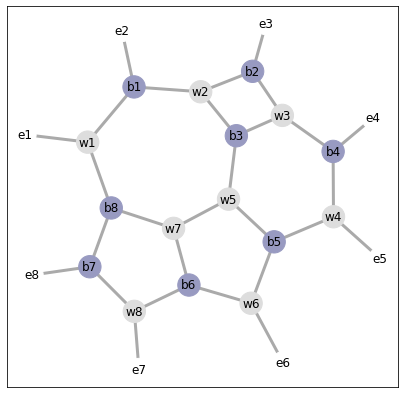

In [3]:
IPython.display.display(IPython.display.HTML('<h2>Starter graph</h2>'))
IPython.display.display(IPython.display.HTML('<img src="starter_graph.png" width="390"/>'))
draw_node_edges(starting_node_edges)

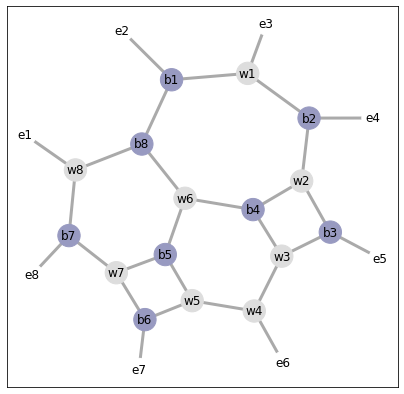

In [4]:
IPython.display.display(IPython.display.HTML('<h2>Solution graph</h2>'))
IPython.display.display(IPython.display.HTML('<img src="solution_graph.png" width="390"/>'))
draw_node_edges(solution_node_edges)

## Determining and executing moves

Two moves are allowed as seen in the initial screenshot. I call these moves 'duo' moves and 'quad moves.

The following class defines the Graph object which is initialized with the 'node_edge' data model above.

A Graph can determine possible moves, execute those moves, and store a history of previous graphs and the 
moves that were made to get to the current graph.

Additionally, Graph objects can be compared to eachother for equivalence using the standard == operator.

In [5]:
class Graph:
    
    def __init__(self, node_edges, previous_graphs=[], previous_moves=['Starter graph'], depth=0):
        ''' Creates a new graph '''
        self.node_edges = copy.deepcopy(node_edges)
        self.depth = depth
        self.previous_graphs = previous_graphs + [self]
        self.previous_moves = previous_moves
        
    def __hash__(self):
        ''' A custom hashing function used for determining if two Graphs are equivalent.
            Two Graphs are considered equivalent if the structure of edges and nodes are the same,
            the color of the nodes is the same (black / white). And the edge node numbers are the
            same.
            
            Note: two Graphs are still considered equivalent even if black or white nodes are numbered 
            differently.
        '''
        return hash_graph(self)
    
    def __eq__(self, other):
        ''' A custom equality function, allowing us to compare if two Graphs are equivalent using the 
            standard == operator '''
        if isinstance(other, Graph):
            return hash(self) == hash(other)
        return False

    def draw(self):
        ''' Displays the graph '''
        draw_node_edges(self.node_edges)

    def get_duo_moves(self):
        ''' Returns a list of 2-tuples containing all same-colored nodes that connect
            and are therefore eligible for a 'duo' move (move #1) 
            
            Example return value: [('w1', 'w2'), ('b3', 'b7')] '''
        duo_moves = []
        for node, destinations in self.node_edges:
            for destination in destinations:
                if node[0] == destination[0] and (destination, node) not in duo_moves:
                    duo_moves.append((node, destination))
        return duo_moves

    def get_quad_moves(self):
        ''' Returns a list of 4-tuples containing nodes that connect in an alternating-colored
            square formation and are therefore eligible for a 'quad' move (move #2) 
            
            Example return value: [('w1', 'b5', 'w7', 'b2')] '''
        quad_moves = []
        potentials = []
        for node, destinations in self.node_edges:
            if node[0] == 'w':
                black_destinations = list(filter(lambda x: x[0] == 'b', destinations))
                black_pairs = get_pairs(black_destinations)
                for black_pair in black_pairs:
                    potentials.append((node, black_pair))
        for i in range(len(potentials)):
            white_node1, black_pair1 = potentials[i]
            for j in range(i + 1, len(potentials)):
                white_node2, black_pair2 = potentials[j]
                if black_pair1 == black_pair2:
                    quad_moves.append((white_node1, black_pair1[0], white_node2, black_pair1[1]))
        return quad_moves

    def execute_duo_move(self, nodes):
        ''' Accepts a duo move (a 2-tuple of nodes) and returns a new Graph in which the
            duo move has been executed '''
        node1, node2 = nodes
        new_node_edges = copy.deepcopy(self.node_edges)
        node1_destinations = list(filter(lambda x: x[0] == node1, self.node_edges))[0][1]
        node2_destinations = list(filter(lambda x: x[0] == node2, self.node_edges))[0][1]
        index1 = (node1_destinations.index(node2) + 1) % len(node1_destinations)
        index2 = (node2_destinations.index(node1) + 1) % len(node2_destinations)
        prev_destination1 = node1_destinations[index1]
        prev_destination2 = node2_destinations[index2]
        for i, (node, destinations) in enumerate(new_node_edges):
            if node == node1:
                destinations[index1] = prev_destination2
                new_node_edges[i] = (node, reverse_destination_order(destinations))
            if node == node2:
                destinations[index2] = prev_destination1
                new_node_edges[i] = (node, reverse_destination_order(destinations))
            if node == prev_destination1:
                index = destinations.index(node1)
                new_node_edges[i][1][index] = node2
            if node == prev_destination2:
                index = destinations.index(node2)
                new_node_edges[i][1][index] = node1
        return Graph(
            new_node_edges, 
            self.previous_graphs,
            self.previous_moves + ['Duo move with {} and {}'.format(node1, node2)],
            self.depth + 1
        )
    
    def execute_quad_move(self, nodes):
        ''' Accepts a quad move (a 4-tuple of nodes) and returns a new Graph in which the
            quad move has been executed '''
        new_node_edges = copy.deepcopy(self.node_edges)
        for i, (node, destinations) in enumerate(new_node_edges):
            if node in nodes:
                index = (nodes.index(node) + 1) % len(nodes)
                new_node_edges[i] = (nodes[index], destinations)
            for j, destination in enumerate(destinations):
                if destination in nodes:
                    index = (nodes.index(destination) + 1) % len(nodes)
                    new_node_edges[i][1][j] = nodes[index]
        return Graph(
            new_node_edges, 
            self.previous_graphs, 
            self.previous_moves + ['Quad move with {}, {}, {}, and {}'.format(*nodes)],
            self.depth + 1
        )
    
    def execute_possible_moves(self):
        ''' Determines all possible duo and quad moves, then returns a list of new Graphs,
            each of which has had one of the possible moves applied to it.
            
            If this Graph is a repeat representation of a Graph stored in previous_graphs,
            then an empty list. 
        '''
        for previous_graph in self.previous_graphs[:-1]:
            if self == previous_graph:
                return []
        return (    
            list(map(self.execute_duo_move, self.get_duo_moves())) +
            list(map(self.execute_quad_move, self.get_quad_moves()))
        )

## Searching for the solution

Now we can perform a breadth-first search for the solution.

We initialize a queue that starts out with only the starting Graph and begin looping.

Each iteration of the loop, we take remove the first Graph from the queue, then determine and
execute all possible moves for that Graph. We add the resulting Graphs to the end of the queue.

If a Graph is determined to be a repeat representation, we do not continue searching down that branch.

In [6]:
target = Graph(solution_node_edges)
queue = [Graph(starting_node_edges)]
solution = None

print('Solving...')
iterations = 0
start_time = time.time()

while True:
    graph = queue.pop(0)
    if graph == target:
        solution = graph
        break
    queue += graph.execute_possible_moves()
    iterations += 1

seconds = round(time.time() - start_time, 2)
print('Solved in {} seconds after searching through {:,} graphs.'.format(seconds, iterations))

Solving...
Solved in 14.47 seconds after searching through 12,000 graphs.


## The solution

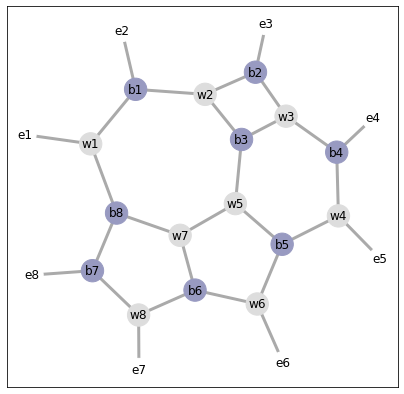

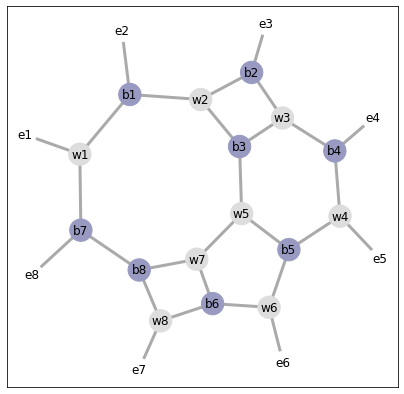

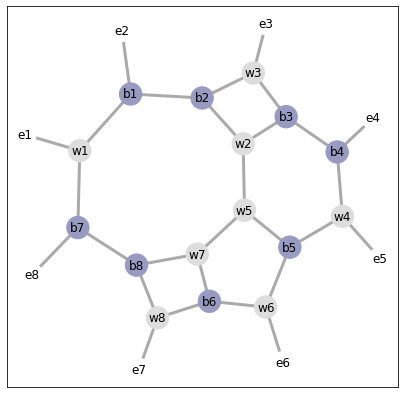

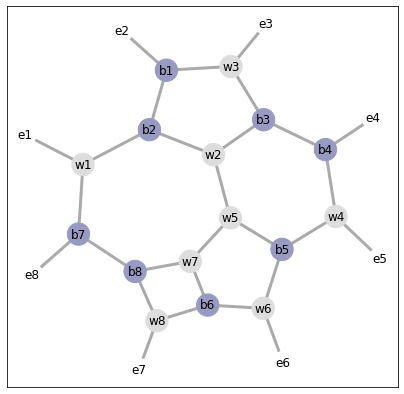

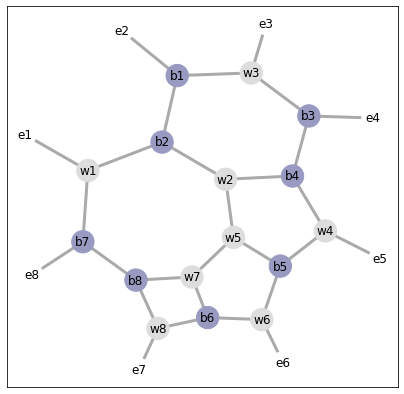

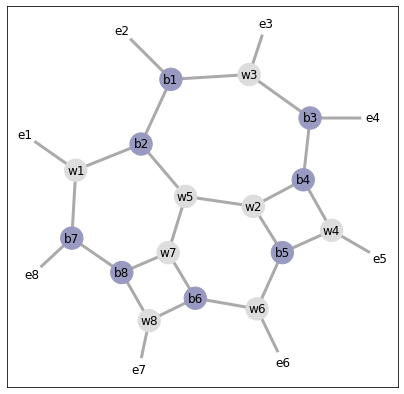

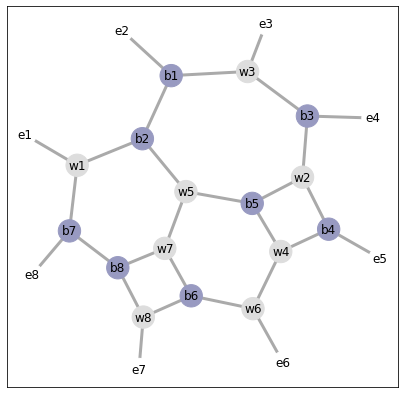

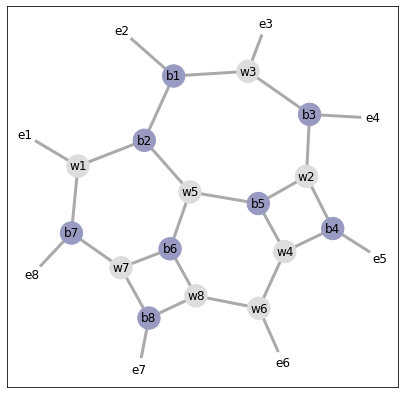

In [7]:
IPython.display.display(IPython.display.HTML('<h2>Starter graph</h2>'))
IPython.display.display(IPython.display.HTML('<img src="starter_graph.png" width="390"/>'))
for i, graph in enumerate(solution.previous_graphs):
    IPython.display.display(IPython.display.HTML('<h2>Step {}: {}</h2>'.format(i + 1, graph.previous_moves[i])))
    graph.draw()
IPython.display.display(IPython.display.HTML('<h2>Solution graph</h2>'))
IPython.display.display(IPython.display.HTML('<img src="solution_graph.png" width="390"/>'))